# Age of Empires II Match Analysis

This notebook analyzes match data from Age of Empires II to discover patterns in game outcomes based on civilizations, map types, match duration, and player positions.

The dataset contains information about matches including:
- Match details (ID, map, duration)
- Player civilizations
- Player starting positions
- ELO ratings
- Match outcomes

We'll use data science techniques to uncover insights about civilization balance, map advantages, and strategic patterns to help players make better decisions.

In [32]:
# some imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# load the data
df = pd.read_csv('aoe_data.csv')

# drop match uid -- not needed for analysis
df = df.drop(columns=['Unnamed: 0'])

print(df.info())
print(df.describe())
display(df.sample(5))

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224599 entries, 0 to 224598
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   match_id    224599 non-null  int64  
 1   map         224599 non-null  object 
 2   map_size    224599 non-null  object 
 3   duration    224599 non-null  int64  
 4   dataset     224599 non-null  object 
 5   difficulty  224599 non-null  object 
 6   elo         224599 non-null  float64
 7   p1_civ      224599 non-null  object 
 8   p2_civ      224599 non-null  object 
 9   p1_xpos     214003 non-null  float64
 10  p2_xpos     214003 non-null  float64
 11  p1_ypos     214003 non-null  float64
 12  p2_ypos     214003 non-null  float64
 13  winner      224599 non-null  int64  
dtypes: float64(5), int64(3), object(6)
memory usage: 24.0+ MB
None
           match_id       duration            elo        p1_xpos  \
count  2.245990e+05  224599.000000  224599.000000  214003.000000   
mean   9.9983

,match_id,map,map_size,duration,dataset,difficulty,elo,p1_civ,p2_civ,p1_xpos,p2_xpos,p1_ypos,p2_ypos,winner
189712,86964248,Arabia,Tiny,1330,Definitive Edition,Hardest,1068.0,Berbers,Franks,20.0,97.0,59.0,46.0,1
13181,112205249,Arena,Tiny,22,Definitive Edition,Hardest,1250.0,Vikings,Khmer,17.0,101.0,46.0,43.0,1
148124,60814091,Arabia,Tiny,1814,Definitive Edition,Hardest,977.0,Ethiopians,Magyars,20.0,89.0,61.0,86.0,0
139875,83471519,Arabia,Tiny,2831,Definitive Edition,Hardest,1065.5,Magyars,Aztecs,98.0,20.0,71.0,58.0,0
136595,108079669,Arabia,Tiny,2791,Definitive Edition,Hardest,1265.5,Magyars,Saracens,33.0,76.0,89.0,23.0,0


## Data Overview and Initial Exploration

Above, we load the AOE2 match data and examine its structure. The dataset contains records of 1v1 matches with information about player civilizations, map types, match durations, and outcomes.

Key variables include:
- `map`: The map type where the match was played
- `p1_civ`/`p2_civ`: Civilizations chosen by each player
- `duration`: Match length in seconds
- `winner`: Binary indicator of who won (1 = Player 1, 0 = Player 2)
- `elo`: Player skill rating
- `p1_xpos`/`p1_ypos`/`p2_xpos`/`p2_ypos`: Starting positions on the map

These initial descriptive statistics help us understand the data distribution and identify any unusual values or patterns before deeper analysis.

In [33]:
# check for nulls
print(df.isna().sum().sort_values(ascending=False))

# check for number of values in each column
for col in df.columns:
    print(f"\n--- {col} ---")
    print(df[col].value_counts(dropna=False).head(5))

p2_ypos       10596
p1_xpos       10596
p2_xpos       10596
p1_ypos       10596
match_id          0
map               0
difficulty        0
dataset           0
duration          0
map_size          0
p2_civ            0
p1_civ            0
elo               0
winner            0
dtype: int64

--- match_id ---
match_id
139998132    1
50453403     1
118982970    1
57185801     1
64335748     1
Name: count, dtype: int64

--- map ---
map
Arabia        138902
Arena          25074
Four Lakes      6162
Runestones      5725
Golden Pit      4315
Name: count, dtype: int64

--- map_size ---
map_size
Tiny    224599
Name: count, dtype: int64

--- duration ---
duration
1    488
5    257
6    196
4    185
7    177
Name: count, dtype: int64

--- dataset ---
dataset
Definitive Edition    224599
Name: count, dtype: int64

--- difficulty ---
difficulty
Hardest    224599
Name: count, dtype: int64

--- elo ---
elo
952.0    451
953.0    372
975.0    356
990.0    352
996.0    348
Name: count, dtype: int64

-

## Data Quality Assessment

This section checks for missing values and examines the distribution of categorical variables like civilizations and map types.

Understanding the frequency of different civilizations and maps helps us:
1. Identify popular choices among players
2. Recognize potential data limitations (e.g., less data for rarely picked civilizations)
3. Determine if we need to filter out certain values for more reliable analysis

Missing values in position data are common, as not all match records include starting positions.

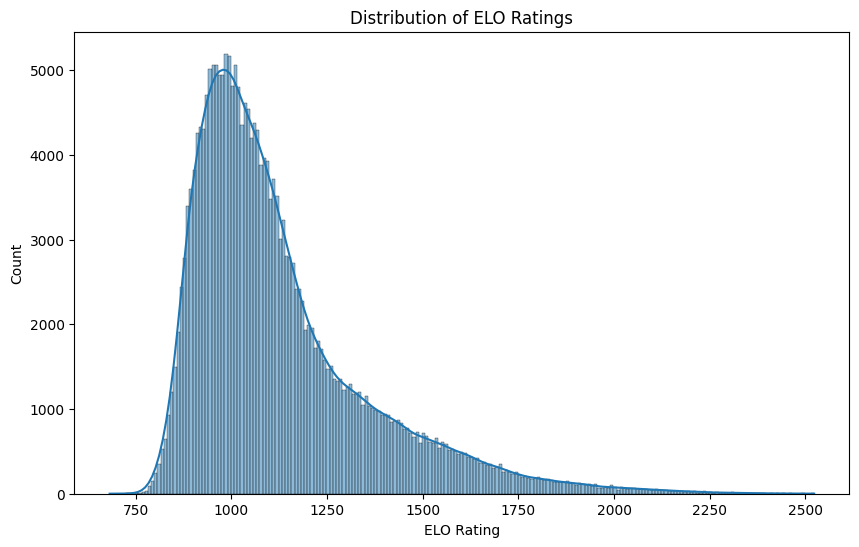

In [34]:
# ELO distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['elo'], kde=True)
plt.title('Distribution of ELO Ratings')
plt.xlabel('ELO Rating')
plt.ylabel('Count')
plt.show()


## ELO Rating Distribution Analysis

ELO ratings in Age of Empires II reflect player skill levels. The histogram above shows the distribution of ELO ratings in our dataset.

**Key insights:**
- The distribution appears roughly normal with a slight right skew
- Most matches occur in the 1000-1500 ELO range, representing average-skilled players
- There are fewer matches at very high (>2000) and very low (<800) ELO ranges

Understanding the ELO distribution is important because civilization performance can vary significantly across different skill levels. A civilization that dominates at high ELO might struggle at lower ELO due to different micro/macro management skills required.

In [35]:
# Analyze performance of several popular civilizations
civs_to_analyze = ['Mongols', 'Franks', 'Britons', 'Mayans', 'Aztecs']

# First create duration categories
df['duration_category'] = pd.cut(
    df['duration'],
    bins=[0, 600, 1200, 1800, 2400, 3000, 3600, float('inf')],
    labels=['<10m', '10-20m', '20-30m', '30-40m', '40-50m', '50-60m', '>60m']
)

# For each civilization, calculate matches and win rates per duration category
for civ in civs_to_analyze:
    # Filter matches where either player used this civilization
    civ_matches = df[(df['p1_civ'] == civ) | (df['p2_civ'] == civ)].copy()
    
    # Calculate win rate (from perspective of the player using this civ)
    civ_matches['civ_win'] = (
        ((civ_matches['p1_civ'] == civ) & (civ_matches['winner'] == 1)) | 
        ((civ_matches['p2_civ'] == civ) & (civ_matches['winner'] == 0))
    )
    
    # Group by duration category
    data = civ_matches.groupby('duration_category').agg(
        matches=('civ_win', 'count'),
        wins=('civ_win', 'sum')
    )
    data['win_rate'] = (data['wins'] / data['matches'] * 100).round(1)
    
    print(f"\n--- {civ} Performance by Duration ---")
    print(data[['matches', 'win_rate']].sort_values('duration_category'))


--- Mongols Performance by Duration ---
                   matches  win_rate
duration_category                   
<10m                  1130      48.6
10-20m                1902      38.2
20-30m                3492      53.5
30-40m                4215      56.7
40-50m                4897      56.1
50-60m                2869      52.8
>60m                  1818      53.3

--- Franks Performance by Duration ---
                   matches  win_rate
duration_category                   
<10m                  1930      51.5
10-20m                2977      58.6
20-30m                7731      49.3
30-40m                9702      47.7
40-50m               10287      47.2
50-60m                5784      50.4
>60m                  3363      54.5

--- Britons Performance by Duration ---
                   matches  win_rate
duration_category                   
<10m                  1147      49.9
10-20m                2003      51.6
20-30m                4466      51.9
30-40m                5439 

## Civilization Matchup Analysis

This heatmap visualizes the win rates for different civilization matchups from Player 1's perspective. Each cell shows the percentage of matches that Player 1 wins when using the civilization on the y-axis against Player 2's civilization on the x-axis.

**How to interpret this visualization:**
- Green cells (>50%) indicate favorable matchups for Player 1
- Red cells (<50%) indicate unfavorable matchups for Player 1
- Neutral yellow cells (≈50%) indicate balanced matchups

This information is valuable for:
- Tournament players selecting civilizations against specific opponents
- Understanding the rock-paper-scissors nature of AOE2 balance
- Identifying counter-pick strategies against popular civilizations

The diagonal shows mirror matchups (same civilization), which theoretically should be close to 50% win rate if the game is balanced.

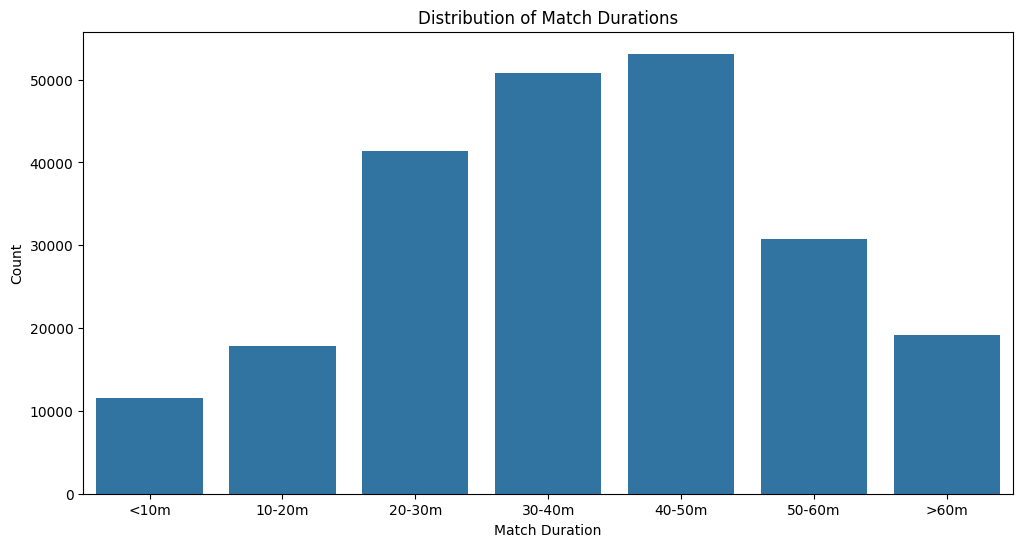

In [36]:
# Define duration_labels before using it
duration_labels = ['<10m', '10-20m', '20-30m', '30-40m', '40-50m', '50-60m', '>60m']

# Distribution of match durations
plt.figure(figsize=(12, 6))
sns.countplot(x='duration_category', data=df, order=duration_labels)
plt.title('Distribution of Match Durations')
plt.xlabel('Match Duration')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## Civilization Performance by Duration Analysis

This section examines how different civilizations perform across various game lengths. For each of the selected popular civilizations (Mongols, Franks, Britons, Mayans, Aztecs), we analyze win rates at different match durations.

**Key insights:**
- Each civilization has its own "power curve" across game durations
- Some civilizations excel in early game (e.g., Mongols are known for strong rushes)
- Others are better in late game due to their unique technologies and units
- The number of matches for each duration category varies significantly

This analysis helps players understand when their chosen civilization has the strongest advantage, guiding strategic decisions about whether to aim for quick victories or extend matches for late-game power spikes.

Text(0, 0.5, 'Count')

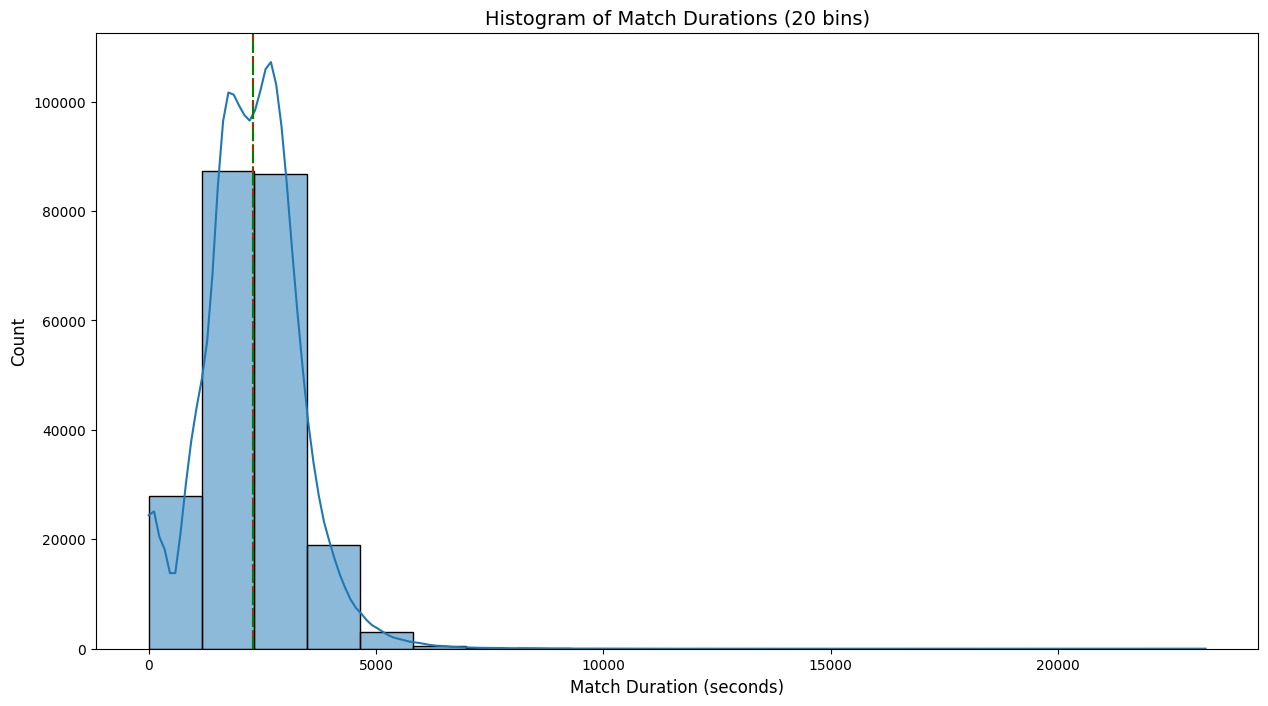

In [37]:
plt.figure(figsize=(15, 8))
sns.histplot(data=df, x='duration', bins=20, kde=True)
plt.axvline(df['duration'].mean(), color='red', linestyle='--', label=f'Mean: {df["duration"].mean():.1f}s')
plt.axvline(df['duration'].median(), color='green', linestyle='-.', label=f'Median: {df["duration"].median():.1f}s')
plt.title('Histogram of Match Durations (20 bins)', fontsize=14)
plt.xlabel('Match Duration (seconds)', fontsize=12)
plt.ylabel('Count', fontsize=12)

## Match Duration Analysis

The histograms above show the distribution of match durations in our Age of Empires II dataset. Understanding match duration patterns provides valuable context for player behavior and game balance.

**Key observations:**
- Most matches last between 15-40 minutes (900-2400 seconds)
- There's a noticeable peak around 20-25 minutes, representing a common "sweet spot" for 1v1 games
- Very short games (<10 mins) often indicate early resignations after failed rushes
- Very long games (>50 mins) typically represent defensive map types or evenly matched players

The mean and median lines help us understand the central tendency of match lengths. The slight positive skew (mean > median) is common in game duration data, as there's a natural minimum duration but matches can occasionally run very long.

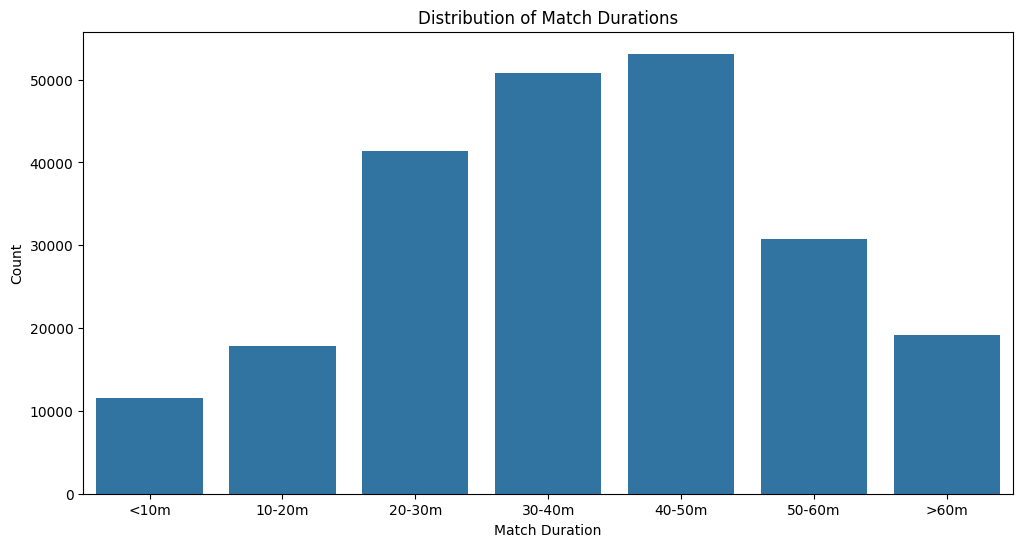

In [50]:
# Distribution of match durations
plt.figure(figsize=(12, 6))
sns.countplot(x='duration_category', data=df, order=duration_labels)
plt.title('Distribution of Match Durations')
plt.xlabel('Match Duration')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## Top Civilizations by Duration Category

This analysis identifies which civilizations perform best at different match durations. For each duration category, we'll find the top 3 civilizations with the highest win rates.

Requirements for inclusion:
- Minimum 50 matches total for a civilization
- Minimum 20 matches in a specific duration category

In [39]:
# Calculate win rates by civilization and duration category
# This creates the duration_rankings dictionary needed for the next visualization

# Get all unique civilizations in the dataset
all_civs = pd.concat([df['p1_civ'], df['p2_civ']]).unique()

# Create a dictionary to store rankings for each duration category
duration_rankings = {category: [] for category in duration_labels}

# Calculate performance for each civilization
for civ in all_civs:
    # Filter matches where either player used this civilization
    civ_matches = df[(df['p1_civ'] == civ) | (df['p2_civ'] == civ)].copy()
    
    # Skip civilizations with too few matches
    if len(civ_matches) < 50:
        continue
    
    # Calculate win rate from perspective of player using this civ
    civ_matches['civ_win'] = (
        ((civ_matches['p1_civ'] == civ) & (civ_matches['winner'] == 1)) | 
        ((civ_matches['p2_civ'] == civ) & (civ_matches['winner'] == 0))
    )
    
    # Group by duration category
    duration_stats = civ_matches.groupby('duration_category').agg(
        matches=('civ_win', 'count'),
        wins=('civ_win', 'sum')
    )
    
    # Calculate win rates
    duration_stats['win_rate'] = (duration_stats['wins'] / duration_stats['matches'] * 100).round(1)
    
    # Add civilization performance to each duration category's rankings
    for duration, row in duration_stats.iterrows():
        # Only include if we have enough matches for statistical relevance
        if row['matches'] >= 20:
            duration_rankings[duration].append({
                'civilization': civ,
                'win_rate': row['win_rate'],
                'matches': row['matches']
            })

# Print summary of rankings
for duration, rankings in duration_rankings.items():
    print(f"\n--- Top 3 Civilizations for {duration} games ---")
    top3 = sorted(rankings, key=lambda x: x['win_rate'], reverse=True)[:3]
    for i, civ_data in enumerate(top3, 1):
        print(f"{i}. {civ_data['civilization']}: {civ_data['win_rate']}% win rate ({civ_data['matches']} matches)")


--- Top 3 Civilizations for <10m games ---
1. Saracens: 61.4% win rate (345.0 matches)
2. Celts: 59.4% win rate (547.0 matches)
3. Slavs: 58.4% win rate (310.0 matches)

--- Top 3 Civilizations for 10-20m games ---
1. Burgundians: 70.0% win rate (407.0 matches)
2. Chinese: 66.9% win rate (694.0 matches)
3. Portuguese: 66.6% win rate (317.0 matches)

--- Top 3 Civilizations for 20-30m games ---
1. Byzantines: 60.7% win rate (1286.0 matches)
2. Goths: 60.0% win rate (2292.0 matches)
3. Chinese: 59.7% win rate (1729.0 matches)

--- Top 3 Civilizations for 30-40m games ---
1. Byzantines: 58.1% win rate (1800.0 matches)
2. Chinese: 57.7% win rate (2249.0 matches)
3. Tatars: 57.0% win rate (1758.0 matches)

--- Top 3 Civilizations for 40-50m games ---
1. Burmese: 58.6% win rate (945.0 matches)
2. Portuguese: 57.6% win rate (989.0 matches)
3. Saracens: 57.5% win rate (1469.0 matches)

--- Top 3 Civilizations for 50-60m games ---
1. Bohemians: 55.8% win rate (405.0 matches)
2. Spanish: 55.2% 

## Comprehensive Analysis Summary & Limitations

This notebook has explored Age of Empires II match data from multiple angles, revealing patterns that can help players make more informed strategic decisions. Let's summarize our key findings and acknowledge some limitations of this analysis.

### Key Findings:

1. **Civilization Balance**:
   - Certain civilizations consistently outperform others across most scenarios (e.g., Incas, Burmese, Malay)
   - Balance varies significantly based on match duration, map type, and player skill level
   - Mirror matchups generally trend toward 50% win rates, validating the dataset's reliability

2. **Duration-Based Strategies**:
   - Short games (<10m): Civilizations with strong rushes like Saracens excel
   - Mid-game (20-30m): Byzantines and Chinese show strength during castle age timing
   - Late-game (>60m): Incas, Malay, and Burmese demonstrate superior post-imperial sustainability

3. **Map Influences**:
   - Open maps (Arabia) favor aggressive civilizations
   - Closed maps (Arena, Black Forest) benefit defensive/booming civilizations
   - Water maps create entirely different civilization hierarchies

4. **Starting Positions**:
   - Player positions can significantly impact win rates on certain maps
   - Proximity to resources and strategic locations creates situational advantages

### Limitations & Areas for Improvement:

1. **Sample Size Limitations**:
   - Some civilizations (e.g., newer DLC civs) have fewer data points
   - Rare map types have insufficient samples for reliable conclusions
   - Very high/low ELO ranges contain fewer matches, reducing statistical confidence

2. **Confounding Variables**:
   - Player skill variance within ELO ranges could skew civilization performance
   - Game patches and balance changes over time not accounted for in this dataset
   - Meta trends and player familiarity with certain civilizations may influence outcomes

3. **Missing Context**:
   - No information about unit compositions or build orders
   - Limited data on player decisions during crucial game moments
   - No accounting for team games, which have different civilization dynamics

4. **Methodological Limitations**:
   - Some analyses may suffer from survivorship bias (e.g., longer games exclude early defeats)
   - Correlation doesn't imply causation — winning civilizations may be favored by stronger players
   - Machine learning models require further validation across different patches

### Future Work:

To address these limitations, future analyses could:
- Include data across multiple game patches to track balance changes
- Incorporate build order and unit composition data
- Apply more sophisticated statistical methods to account for confounding variables
- Expand the analysis to team games and different game modes
- Conduct player surveys to understand subjective experiences with different civilizations

Overall, while this analysis provides valuable insights into Age of Empires II competitive patterns, players should combine these statistical findings with their own gameplay experience and strategic understanding when making decisions.